# 1. Importing and preparing data

In [2]:
%pip install scanpy scipy umap-learn leidenalg
%pip install requests_cache
#%pip install git+https://github.com/pcahan1/PySingleCellNet/
#%pip install scikit-misc
#%pip install -U scFates
#%pip install -q git+https://github.com/theislab/cellrank
#%pip install git+https://github.com/CahanLab/oneSC.git
%pip install requests

#import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import requests_cache
import json
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#import pySingleCellNet as cn
#import skmisc
#import scFates as scf
#import scvelo as scv
#import cellrank as cr
#import onesc
#import networkx as nx
import warnings
import requests
import requests_cache

#os.environ['R_HOME'] = sys.exec_prefix+"/lib/R/"
#cr.settings.verbosity = 2
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 300

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# LaTeX supplement for matplotlib

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 16,
    "font.size": 16,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "text.latex.preamble": r"\usepackage{amsmath,amssymb}"
})

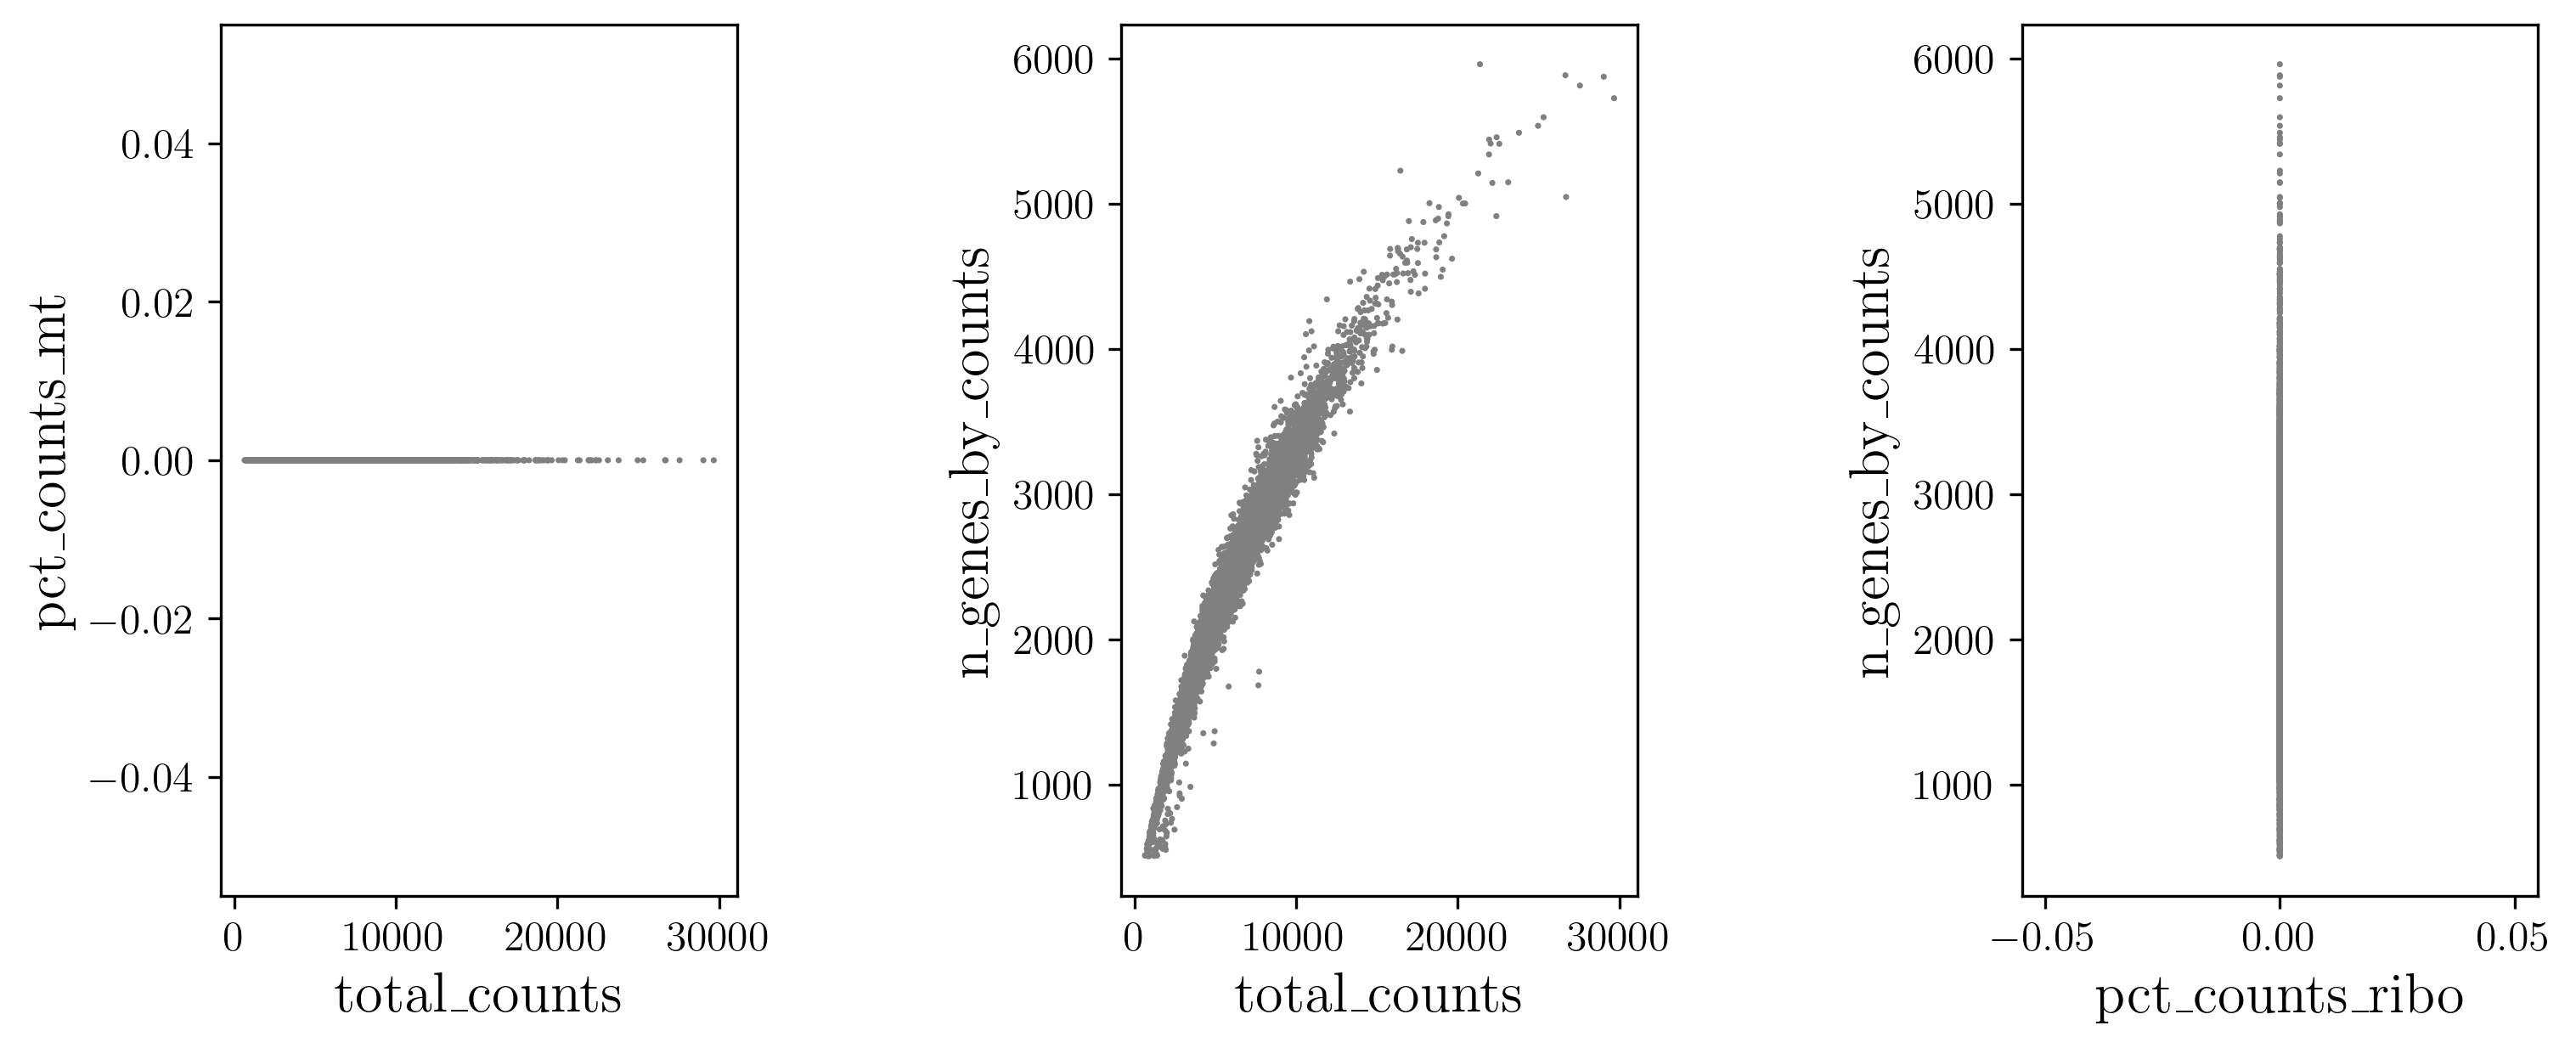

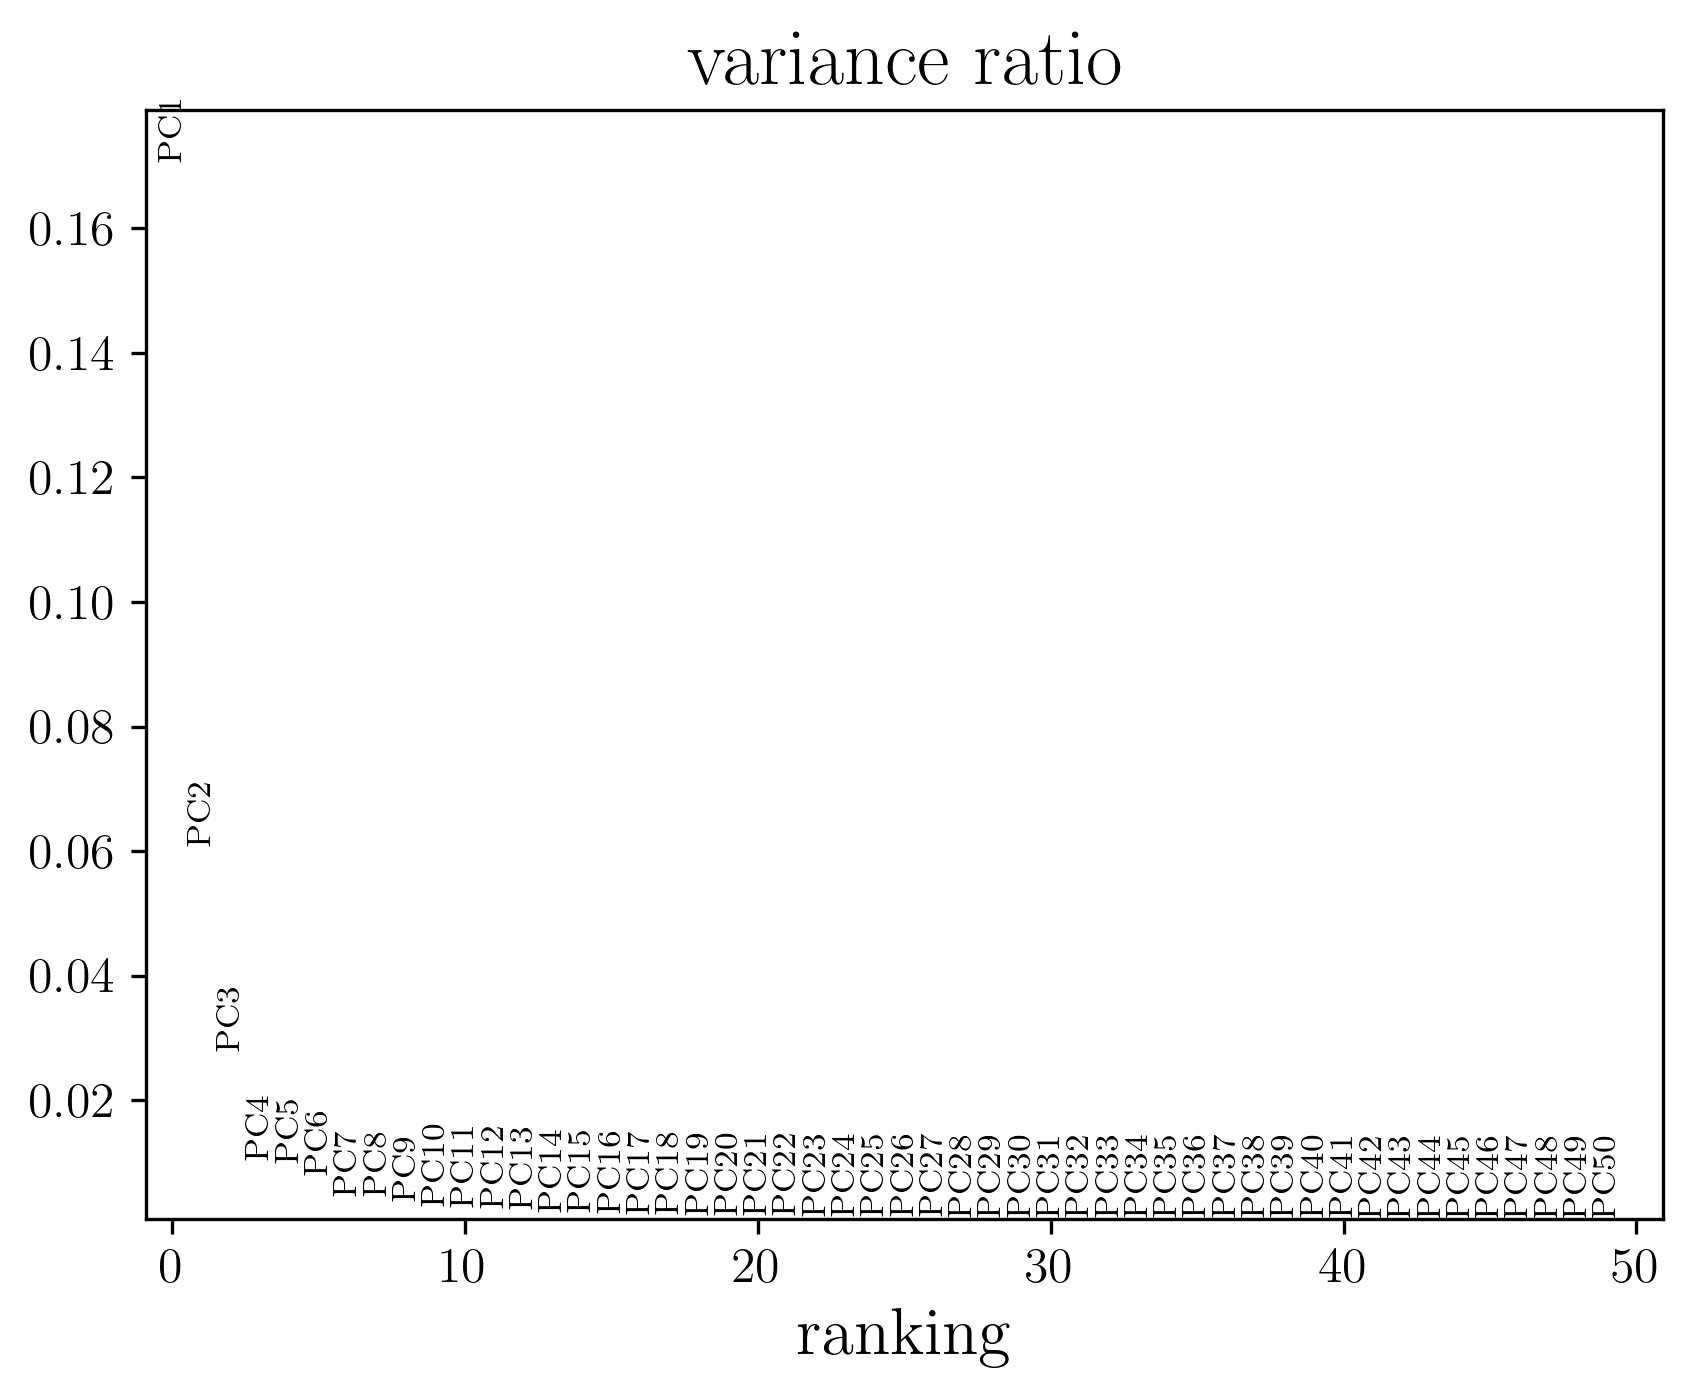

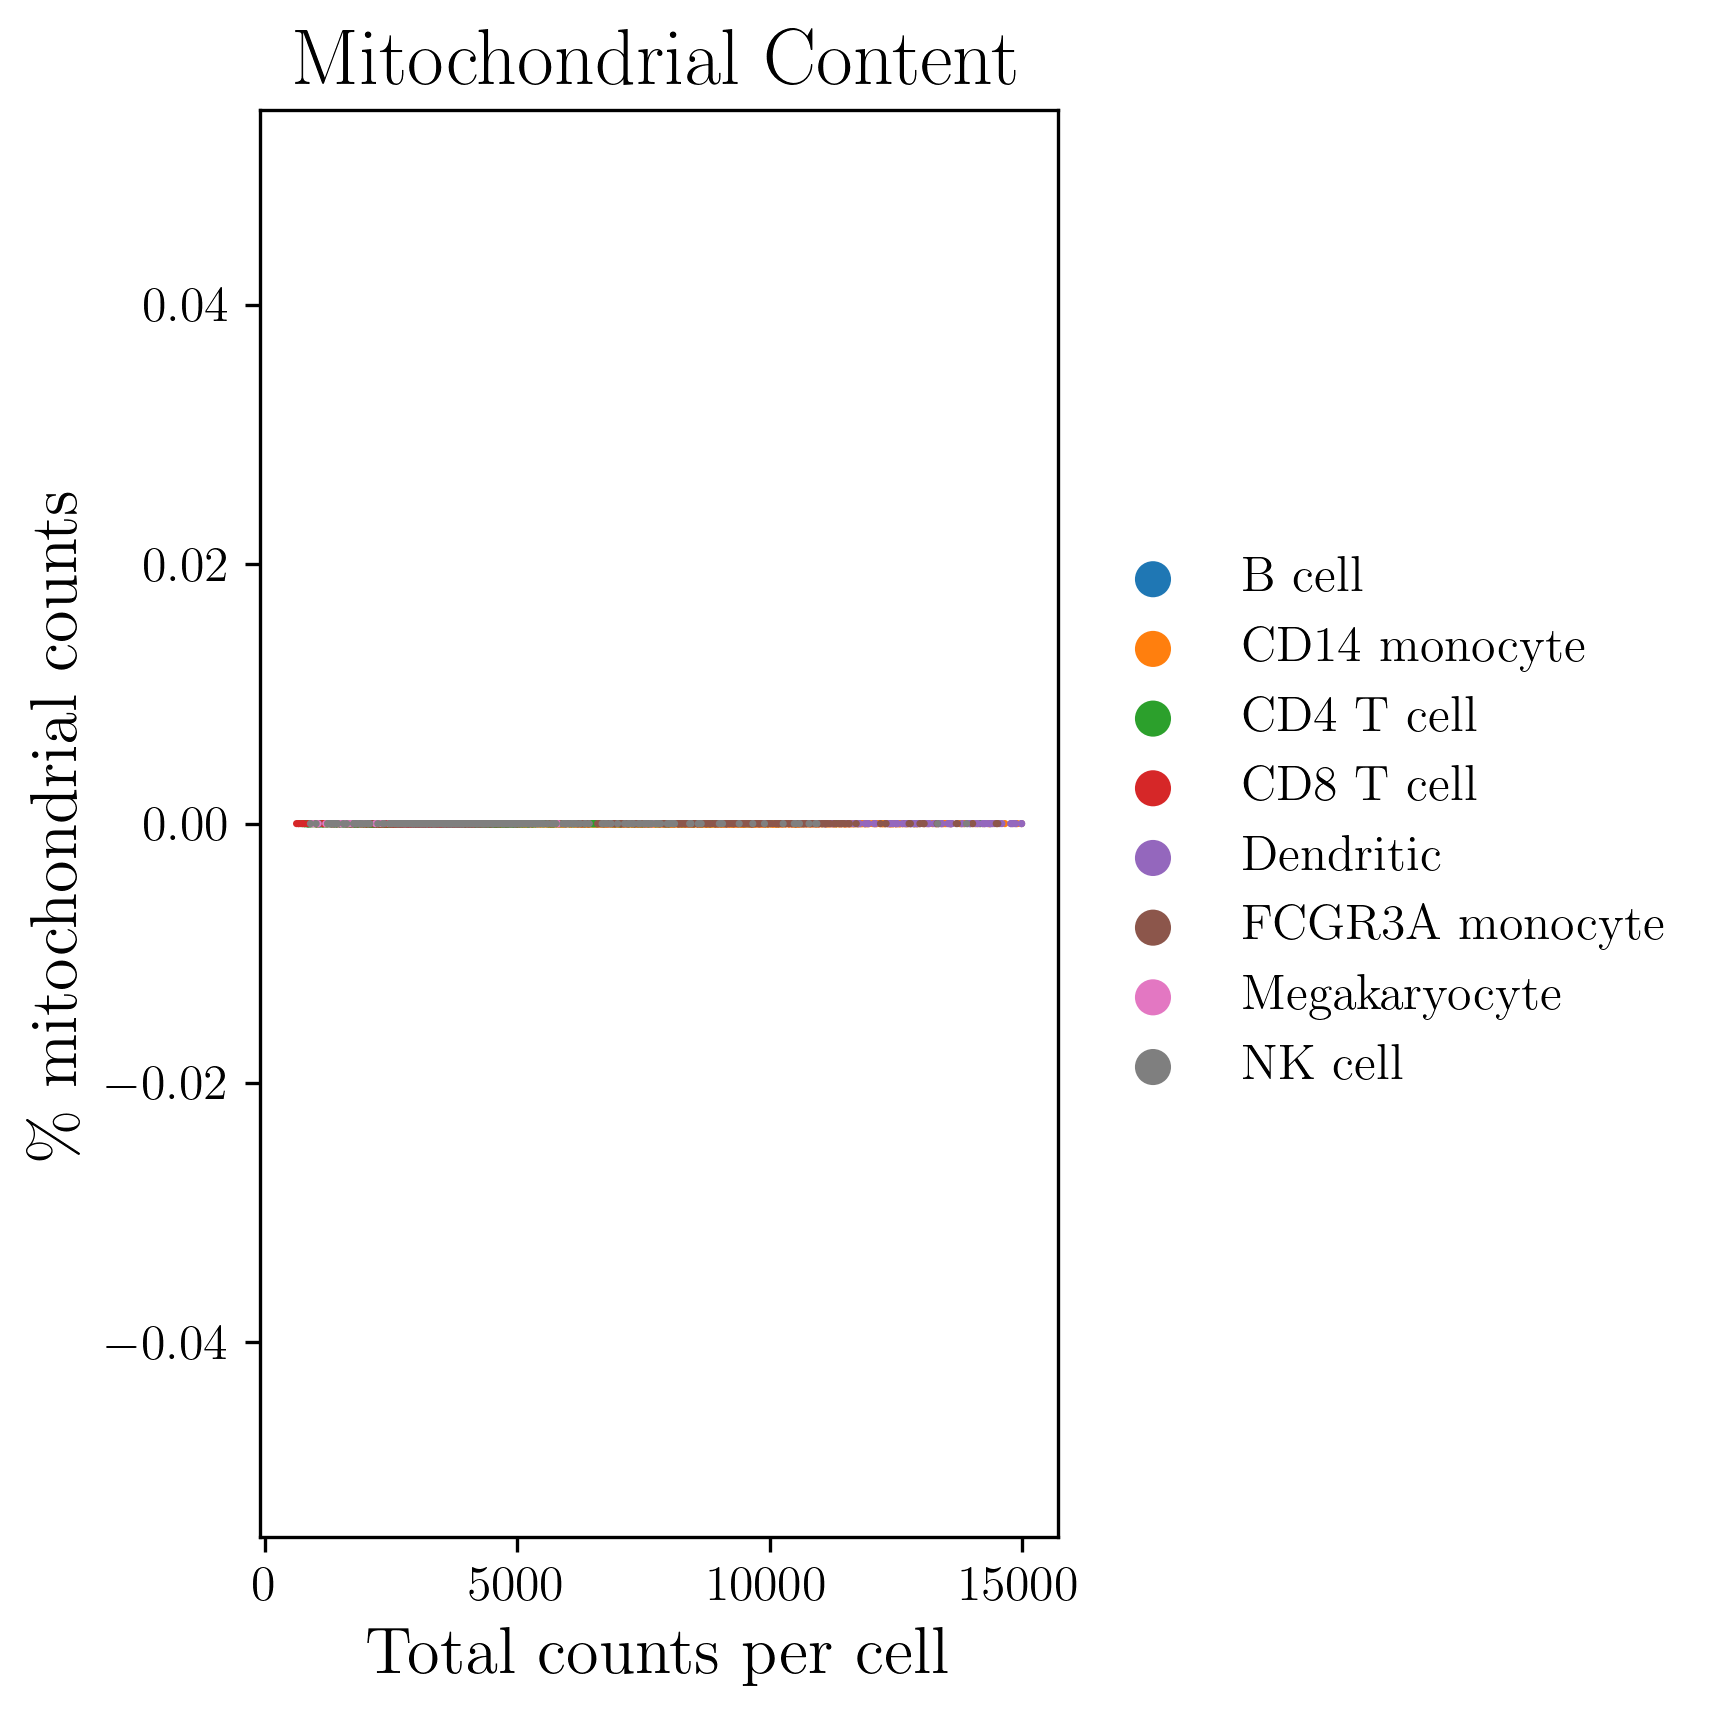

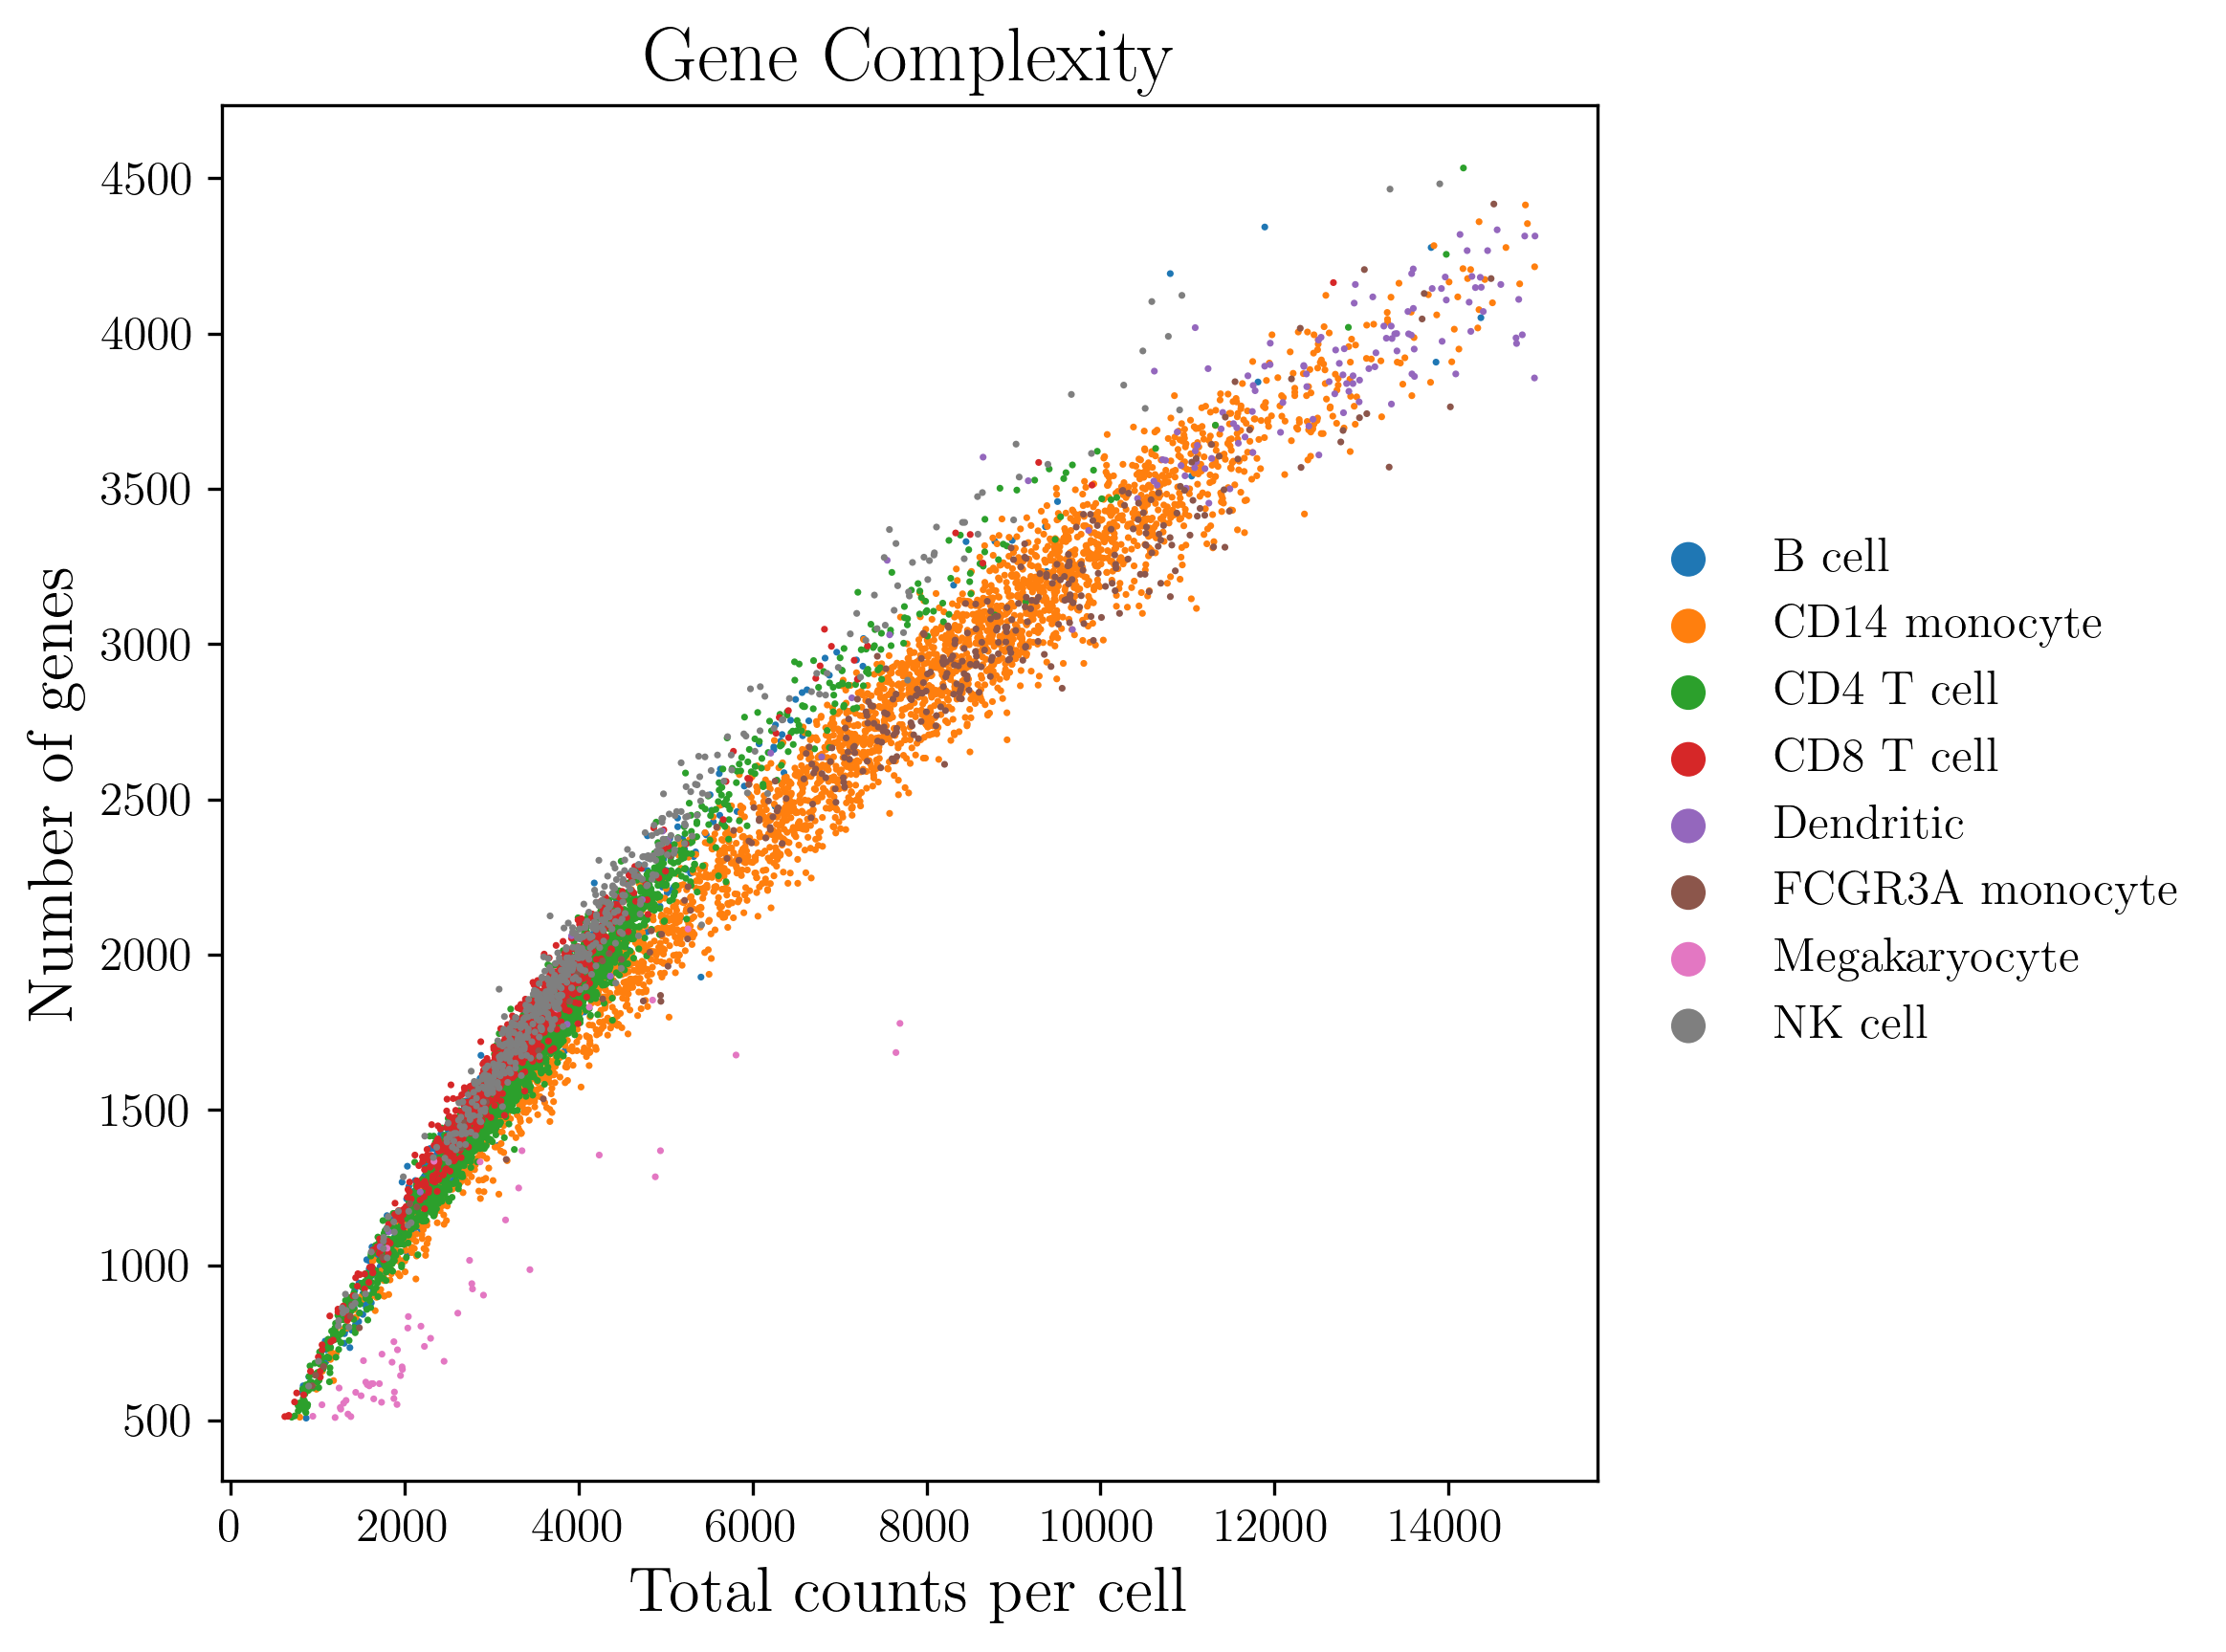

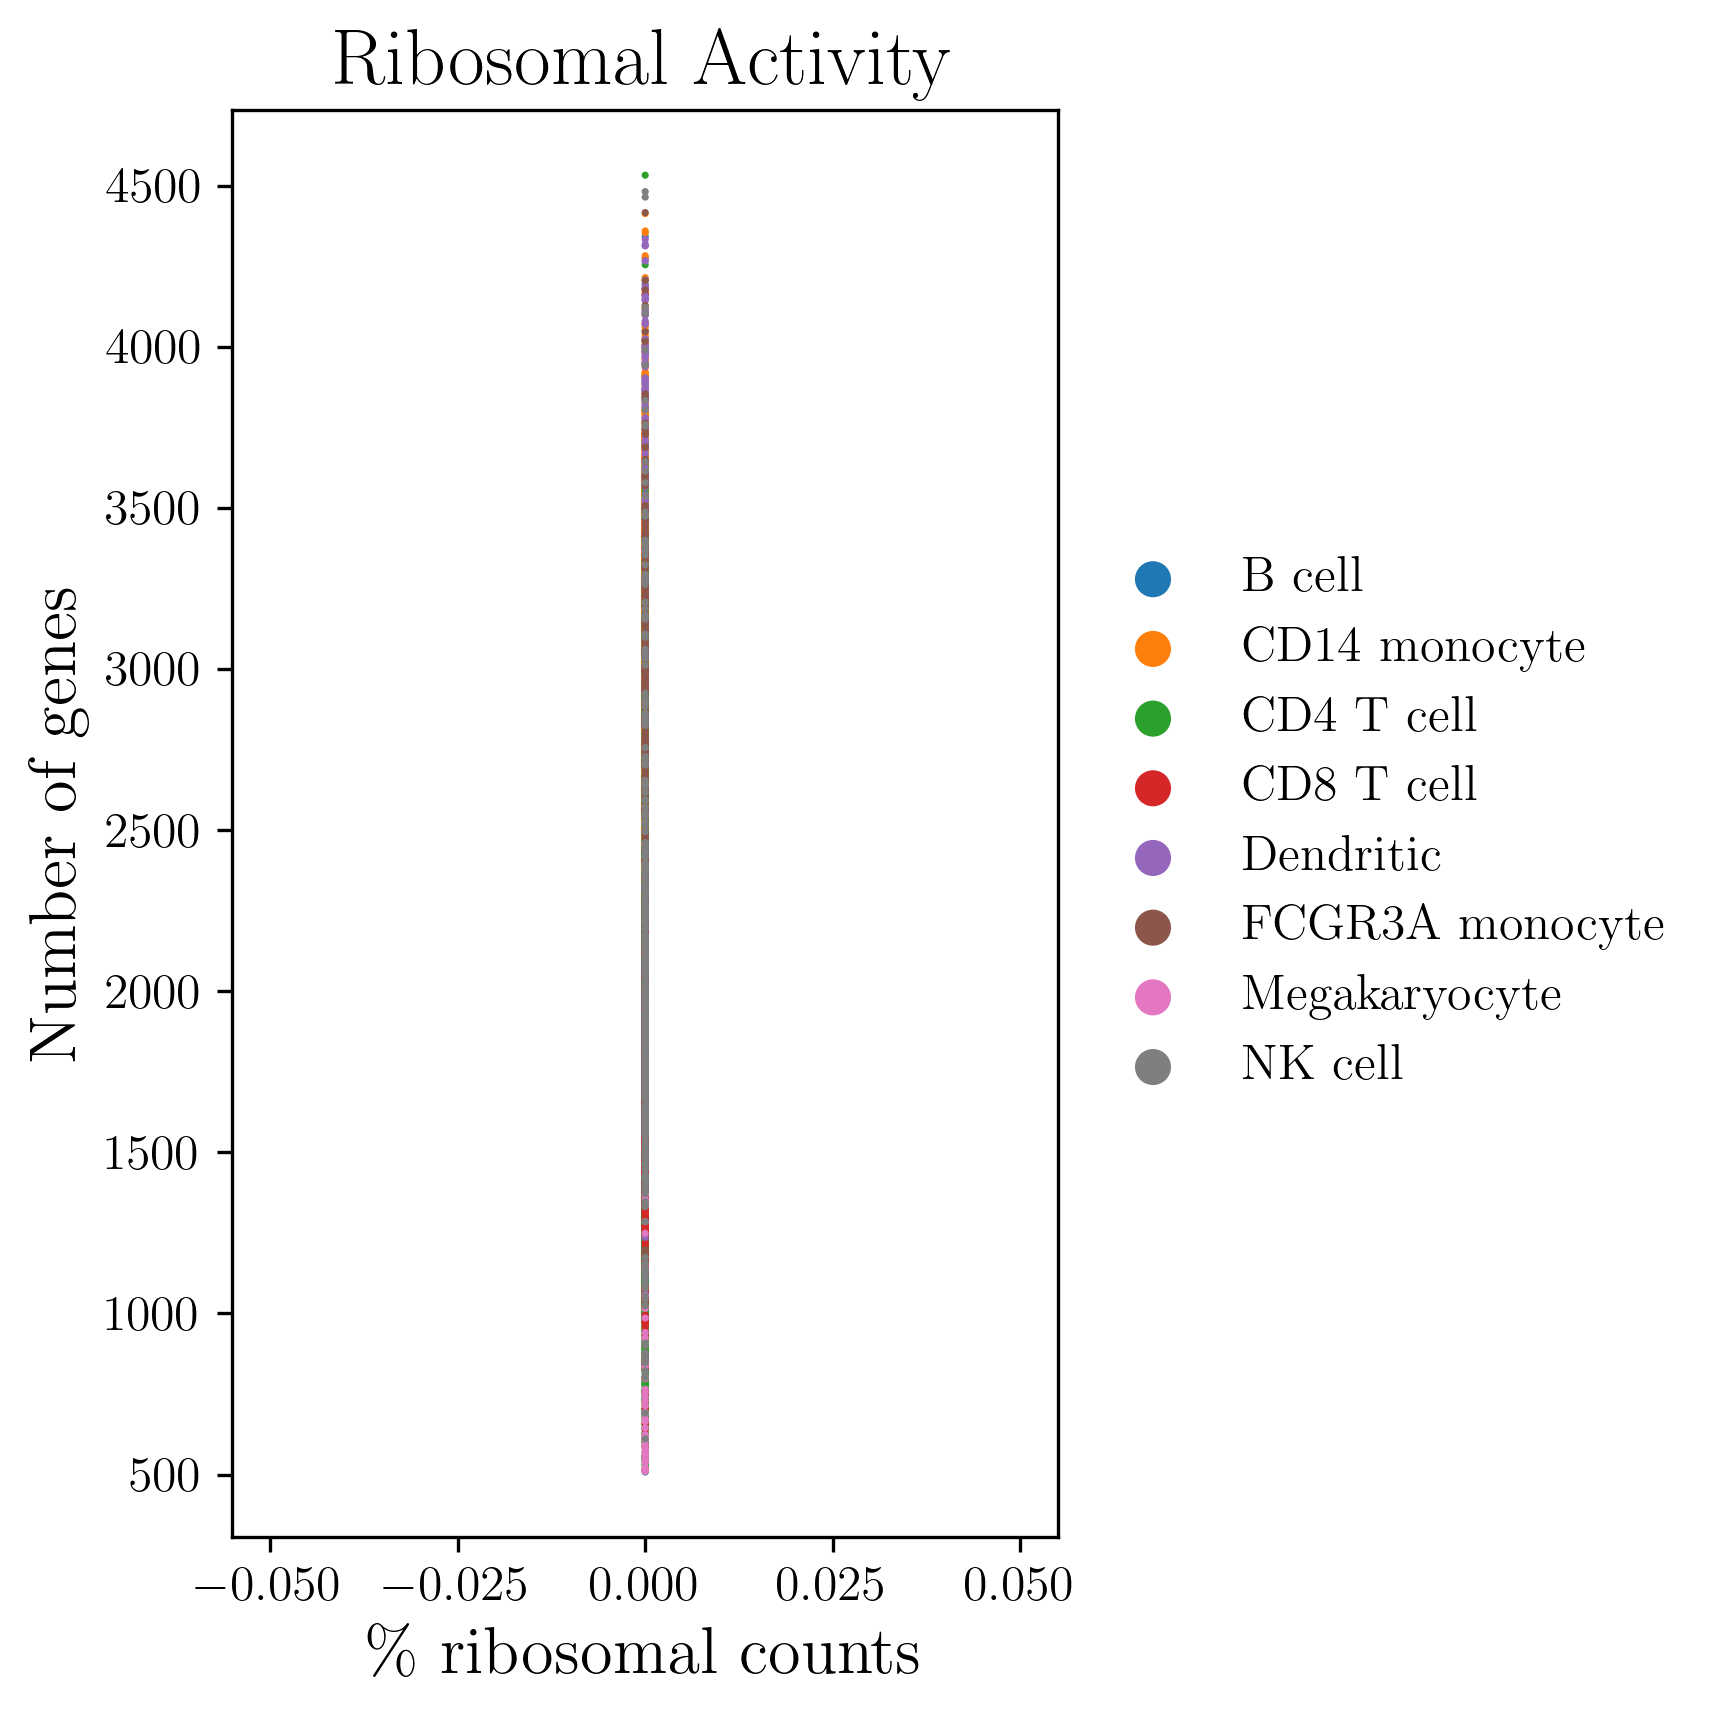

In [4]:
# import and clean up data

cna_bench = sc.read_h5ad('PBMC_simulated_cnas_041025.h5ad')
cna_bench.var_names_make_unique()

# quality control
cna_bench.var['mt'] = cna_bench.var_names.str.startswith('MT-')   # filtering to keep genes expressed in mitochondria
ribo_prefix = ('RPS','RPL')
cna_bench.var['ribo'] = cna_bench.var_names.str.startswith(ribo_prefix)   # filtering to keep genes expressed in ribosomes
sc.pp.calculate_qc_metrics(cna_bench, qc_vars=['mt', 'ribo'], percent_top = None, log1p = False, inplace = True)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10,4), gridspec_kw = {'wspace':0.25}, constrained_layout = True)
ax1_dict = sc.pl.scatter(cna_bench, x = 'total_counts', y = 'pct_counts_mt', ax = ax1, show = False)
ax2_dict = sc.pl.scatter(cna_bench, x = 'total_counts', y = 'n_genes_by_counts', ax = ax2, show = False)
ax3_dict = sc.pl.scatter(cna_bench, x = 'pct_counts_ribo', y = 'n_genes_by_counts', ax = ax3, show = False)
plt.show()
# to visualize distribution of genes to determine how to filter them

sc.pp.filter_cells(cna_bench, min_genes = 500)   # min amount of genes shown on plots #2 and 3
sc.pp.filter_cells(cna_bench, max_counts = 15000)  # where total_counts starts to trail off
sc.pp.filter_genes(cna_bench, min_cells = 3)   # to limit to not have too many rare/unnecessary samples

# normalization
cna_benchnorm = cna_bench.copy()
cna_benchnorm.layers['counts'] = cna_benchnorm.X.copy()
sc.pp.normalize_total(cna_benchnorm, target_sum = 1e4)
sc.pp.log1p(cna_benchnorm)
cna_benchnorm.layers['lognorm'] = cna_benchnorm.X.copy()

# highly variable genes
sc.pp.highly_variable_genes(cna_benchnorm, min_mean = 0.0125, max_mean = 6, min_disp = 0.25)

# principal component analysis
sc.tl.pca(cna_benchnorm, mask_var = 'highly_variable')
sc.pl.pca_variance_ratio(cna_benchnorm, 50)
n_neighbors = 10
n_pcs = 15  # set n_pcs = 15 because this is where asymptote flattens


# ensure relevant metadata is available
if 'cell_type' not in cna_bench.obs.columns:
    print("Warning: 'cell_type' not found in .obs; fallback to default coloring")
    color = None
else:
    color = 'cell_type'

# --- Plot 1: Mitochondrial Percent vs Total Counts ---
fig, ax1 = plt.subplots(figsize=(6, 6))
sc.pl.scatter(
    cna_bench, x='total_counts', y='pct_counts_mt',
    color=color, ax=ax1, show=False, title='Mitochondrial Content'
)
ax1.set_xlabel(r'Total counts per cell')
ax1.set_ylabel(r'$\%$ mitochondrial counts')
ax1.grid(False)
plt.tight_layout()
plt.show()

# --- Plot 2: Total Counts vs Number of Genes (Square, Detailed) ---
fig, ax2 = plt.subplots(figsize=(8, 8))
sc.pl.scatter(
    cna_bench, x='total_counts', y='n_genes_by_counts',
    color=color, ax=ax2, show=False, title='Gene Complexity'
)
ax2.set_xlabel(r'Total counts per cell')
ax2.set_ylabel(r'Number of genes')
ax2.set_box_aspect(1)  # Ensures square axis box
ax2.grid(False)
plt.tight_layout()
plt.show()

# --- Plot 3: Ribosomal Percent vs Number of Genes ---
fig, ax3 = plt.subplots(figsize=(6, 6))
sc.pl.scatter(
    cna_bench, x='pct_counts_ribo', y='n_genes_by_counts',
    color=color, ax=ax3, show=False, title='Ribosomal Activity'
)
ax3.set_xlabel(r'$\%$ ribosomal counts')
ax3.set_ylabel(r'Number of genes')
ax3.grid(False)
plt.tight_layout()
plt.show()


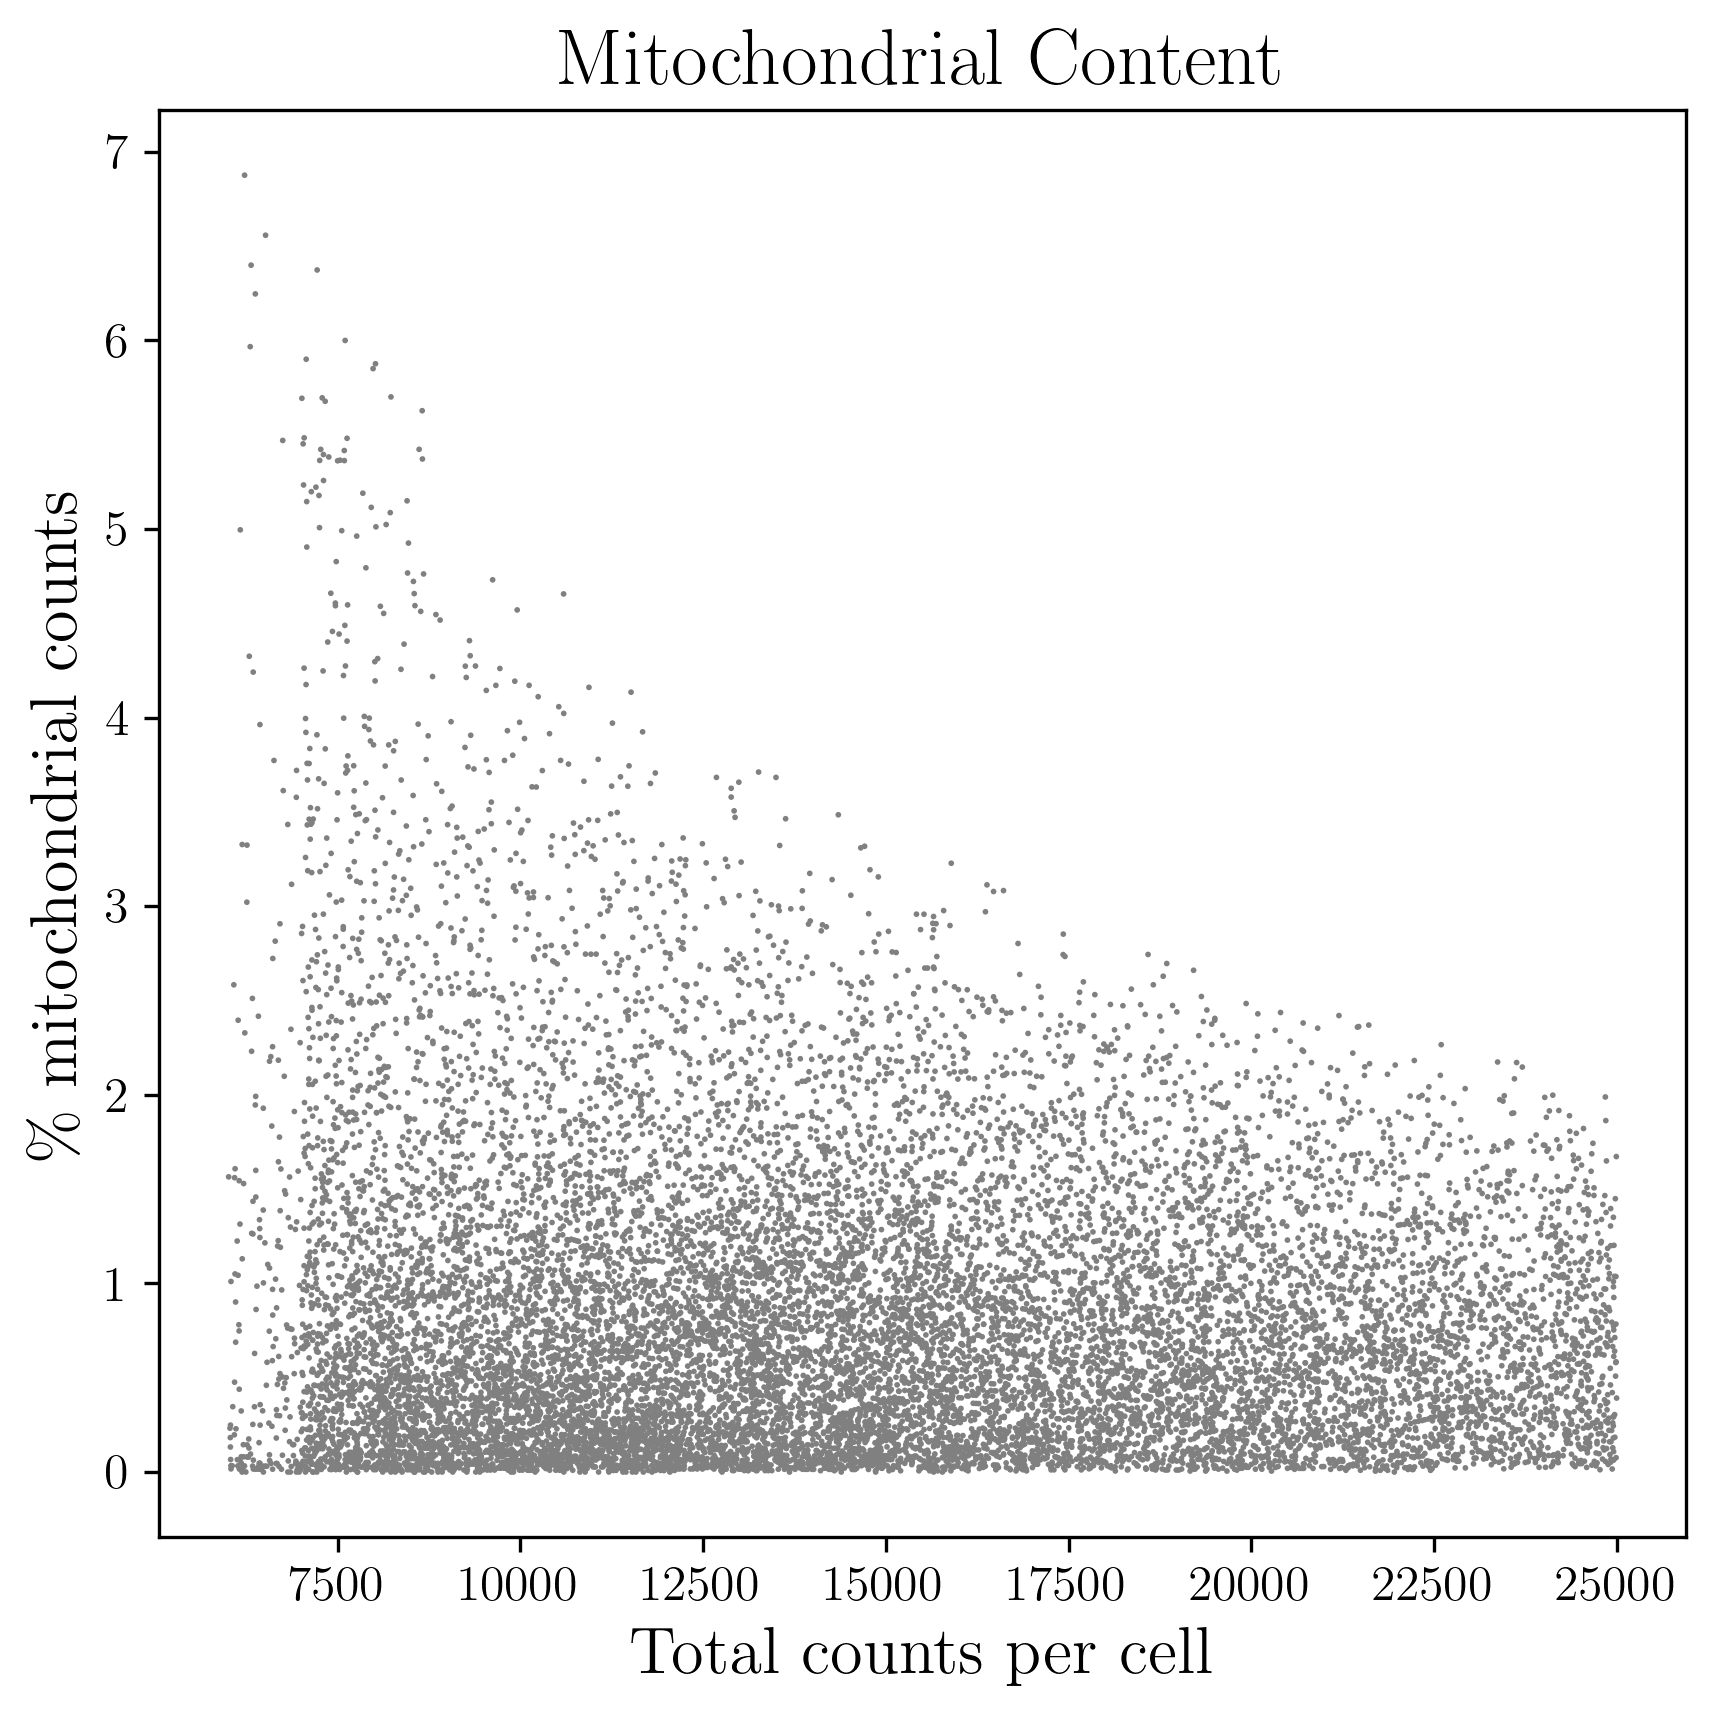

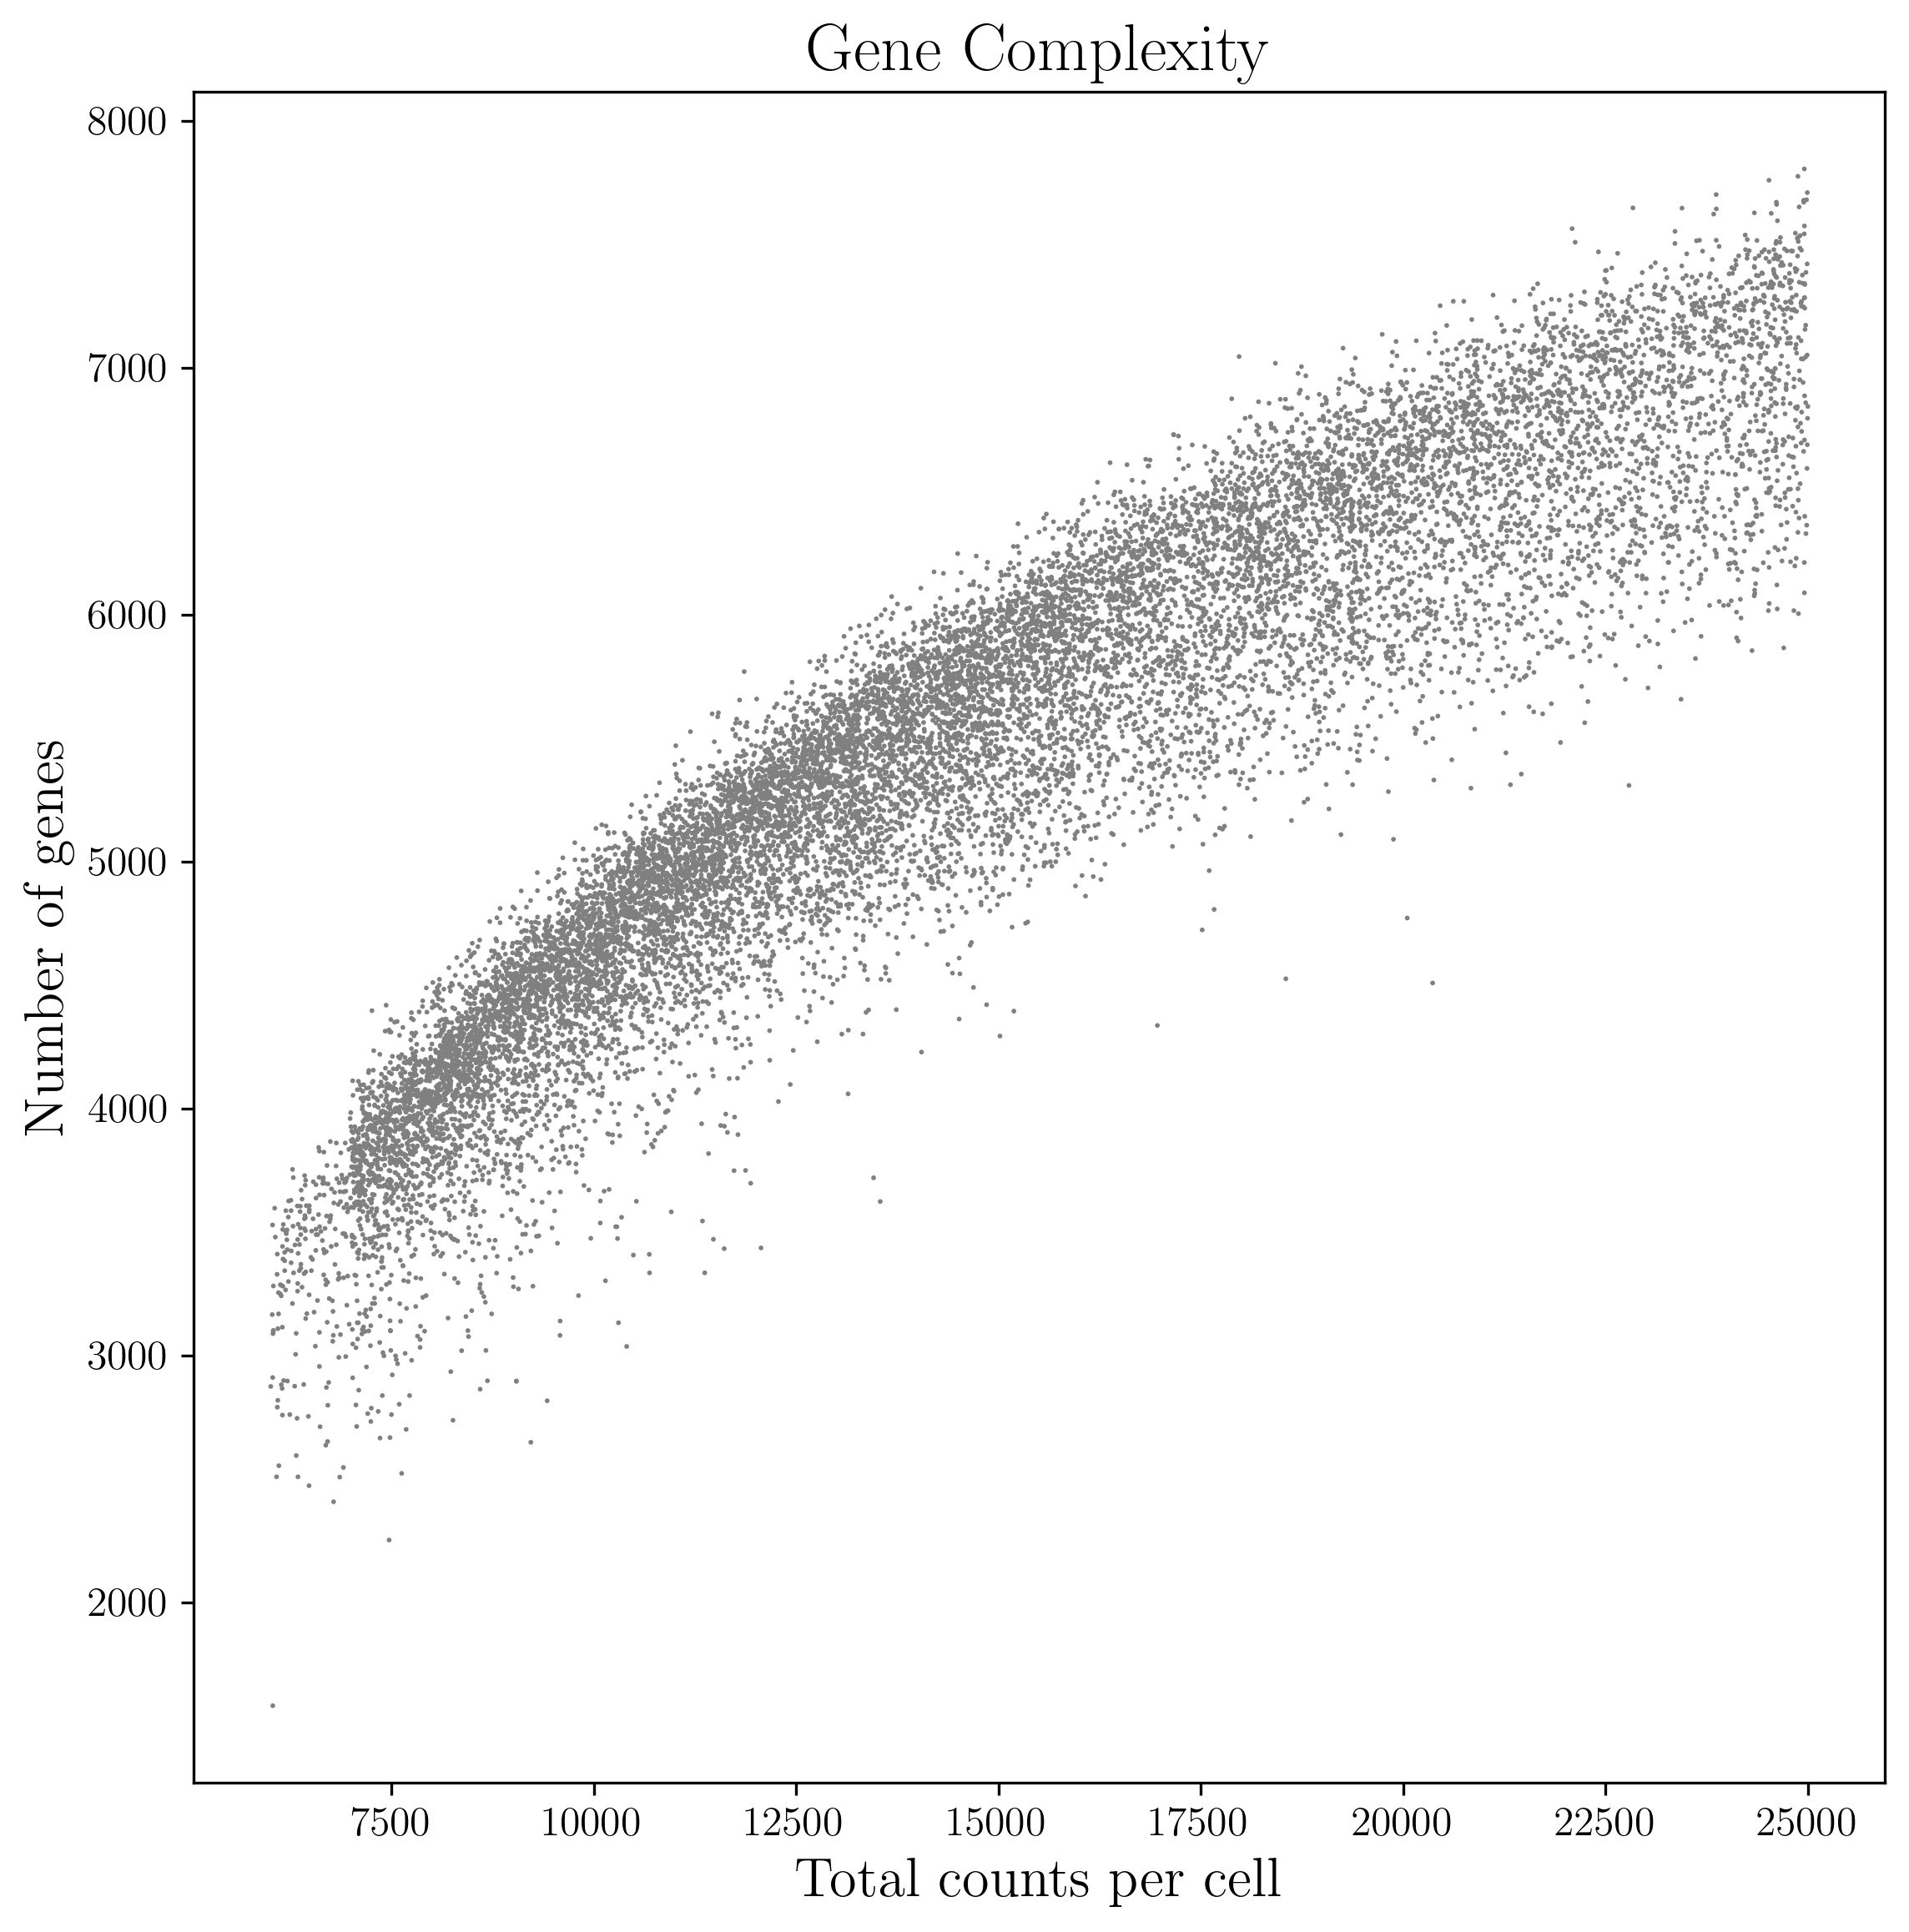

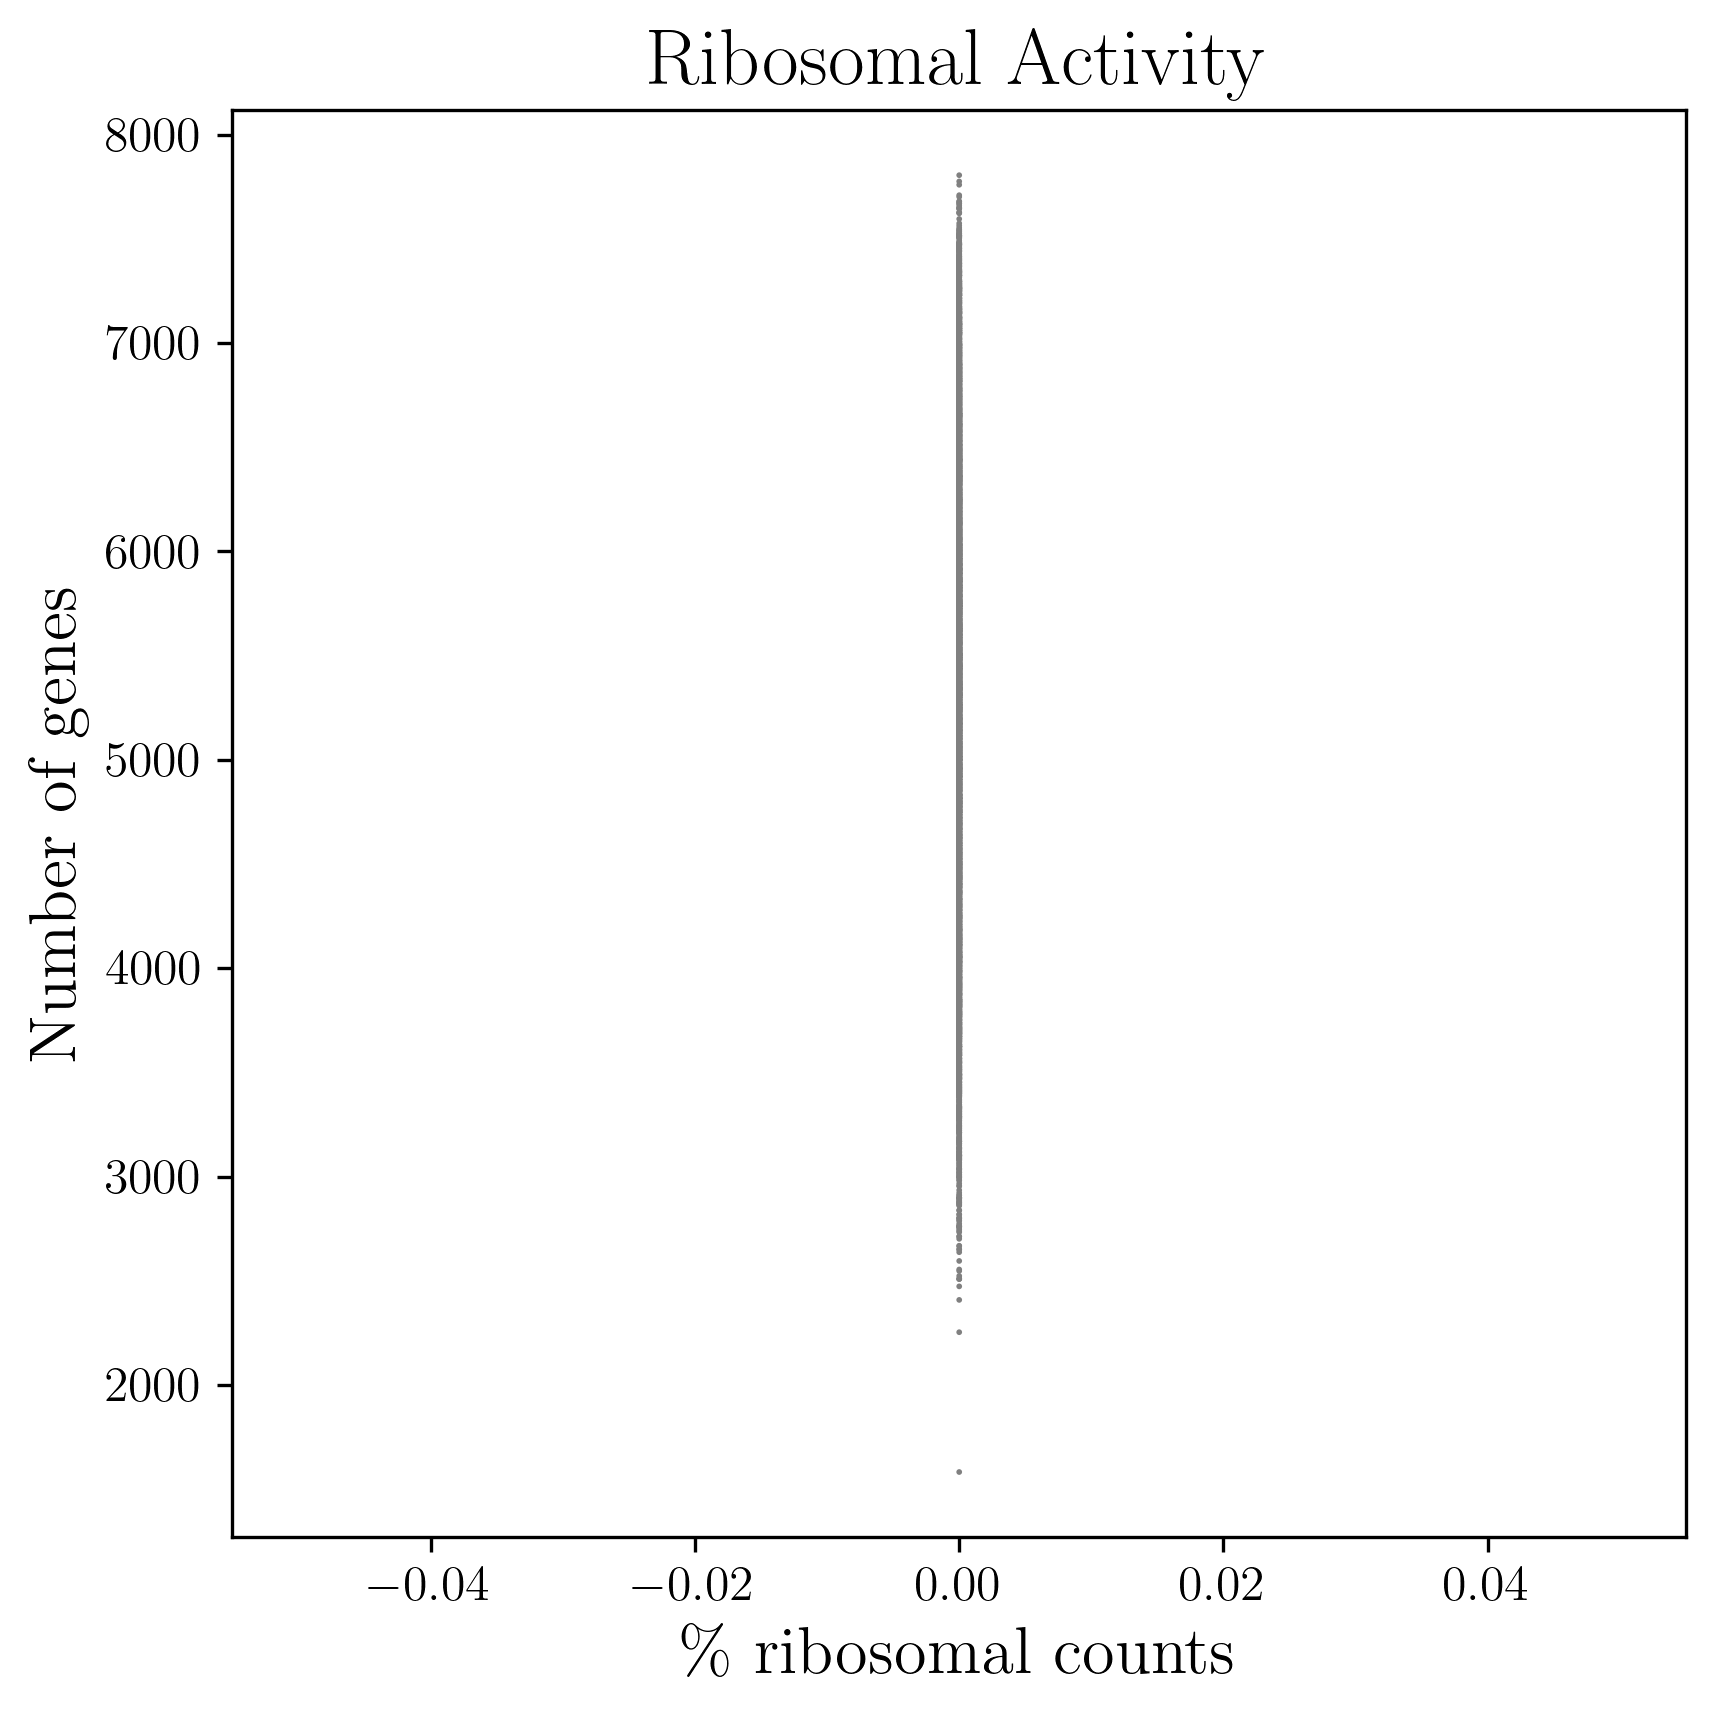

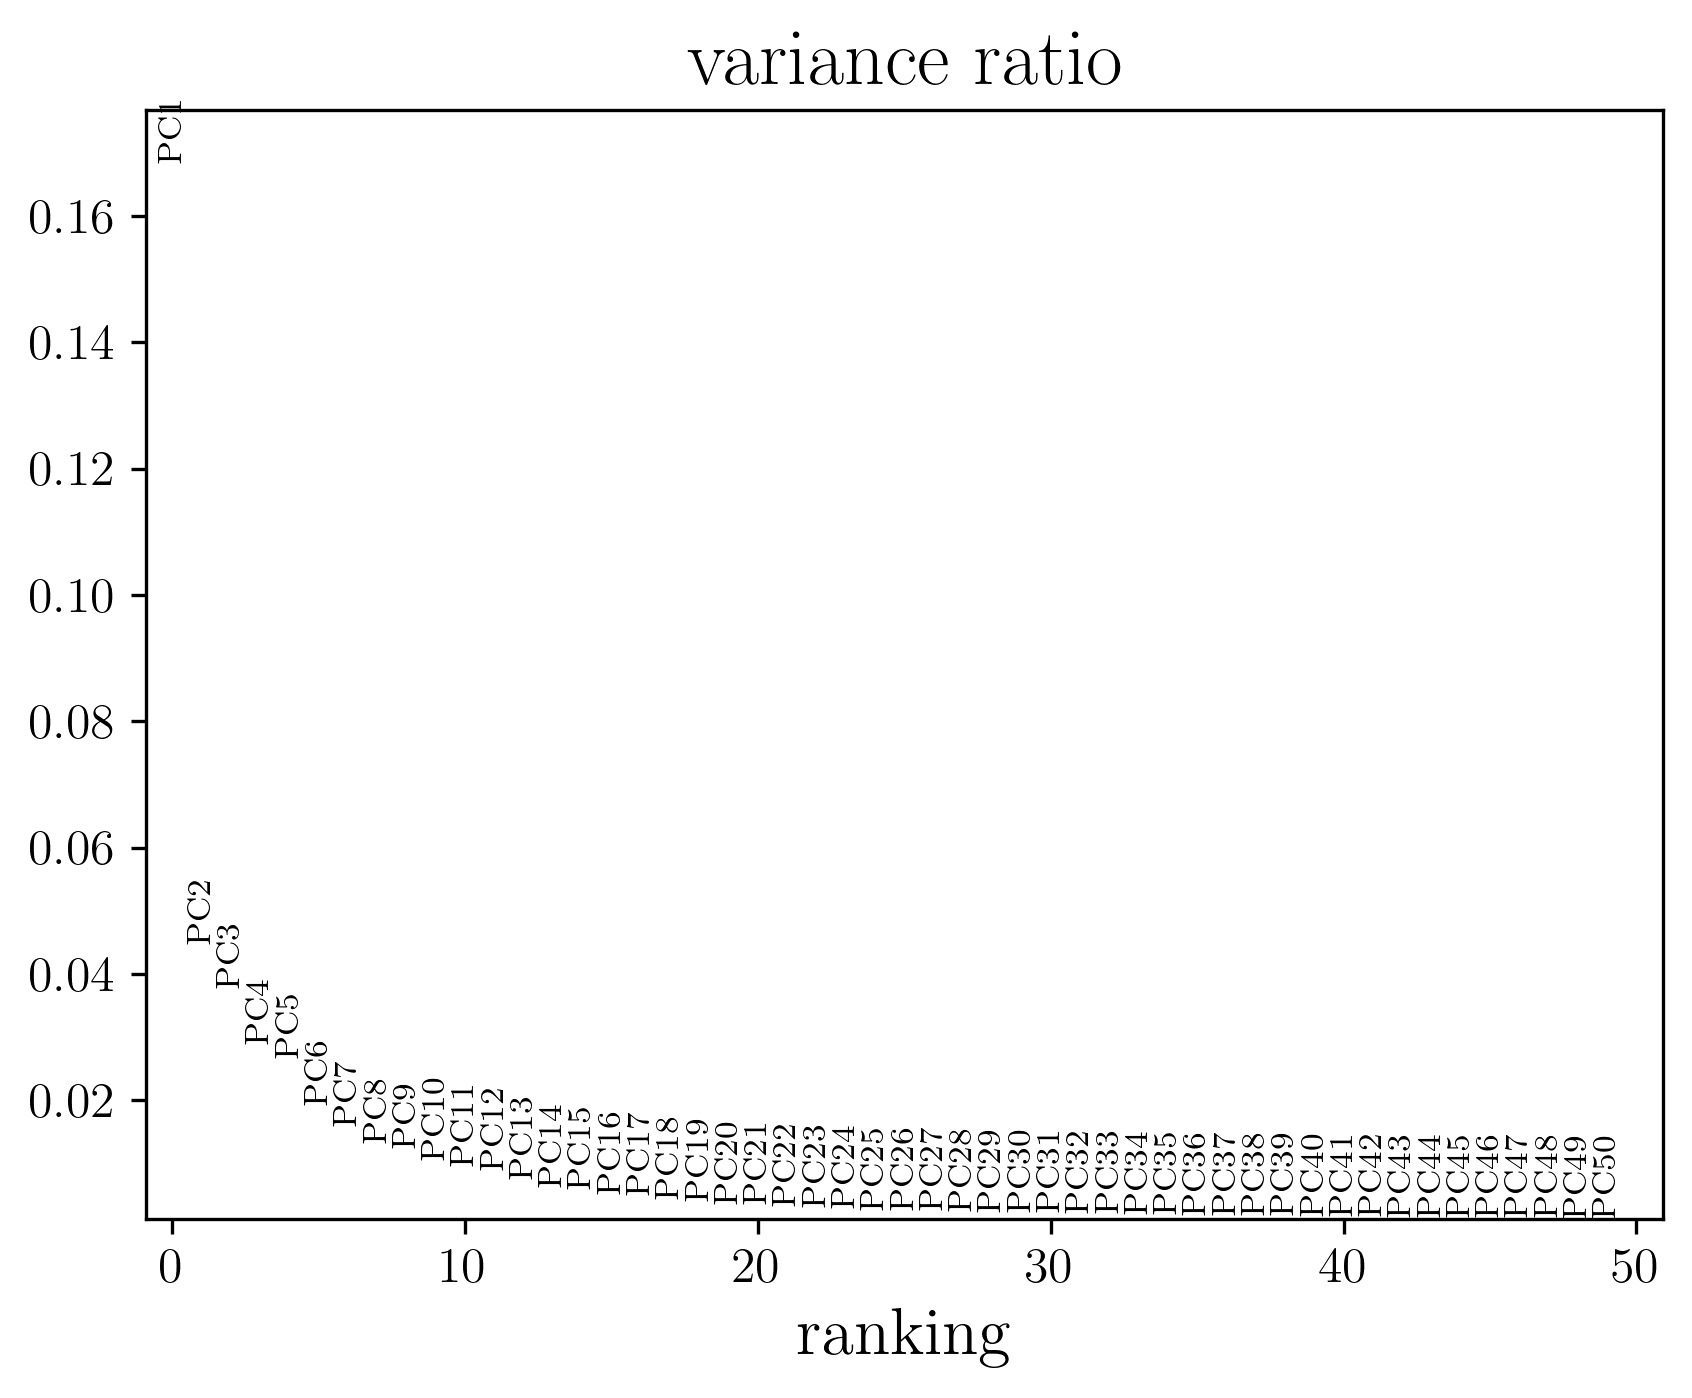

In [5]:
# Load and prepare data
data1 = sc.read_h5ad('GSM8633801_adata_timeseries_new_D6-10_filtered_qc.h5ad')
data1.var_names_make_unique()

# Annotate mitochondrial and ribosomal genes
data1.var['mt'] = data1.var_names.str.startswith('MT-')
ribo_prefix = ('RPS', 'RPL')
data1.var['ribo'] = data1.var_names.str.startswith(ribo_prefix)

# Compute quality control metrics
sc.pp.calculate_qc_metrics(data1, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

# Define coloring
color = 'cell_type' if 'cell_type' in data1.obs.columns else None

# Ensure relevant metadata is available
if 'cell_type' not in data1.obs.columns:
    print("Warning: 'cell_type' not found in .obs; fallback to default coloring")
    color = None
else:
    color = 'cell_type'


# --- Plot 1: Mitochondrial Percent vs Total Counts ---
fig, ax1 = plt.subplots(figsize=(6, 6))
sc.pl.scatter(
    data1, x='total_counts', y='pct_counts_mt',
    color=color, ax=ax1, show=False, title='Mitochondrial Content'
)
ax1.set_xlabel(r'Total counts per cell')
ax1.set_ylabel(r'$\%$ mitochondrial counts')
ax1.grid(False)
plt.tight_layout()
plt.show()

# --- Plot 2: Total Counts vs Number of Genes (Square) ---
fig, ax2 = plt.subplots(figsize=(8, 8))
sc.pl.scatter(
    data1, x='total_counts', y='n_genes_by_counts',
    color=color, ax=ax2, show=False, title='Gene Complexity'
)
ax2.set_xlabel(r'Total counts per cell')
ax2.set_ylabel(r'Number of genes')
ax2.set_box_aspect(1)
ax2.grid(False)
plt.tight_layout()
plt.show()

# --- Plot 3: Ribosomal Percent vs Number of Genes ---
fig, ax3 = plt.subplots(figsize=(6, 6))
sc.pl.scatter(
    data1, x='pct_counts_ribo', y='n_genes_by_counts',
    color=color, ax=ax3, show=False, title='Ribosomal Activity'
)
ax3.set_xlabel(r'$\%$ ribosomal counts')
ax3.set_ylabel(r'Number of genes')
ax3.grid(False)
plt.tight_layout()
plt.show()


# --- Filtering ---
sc.pp.filter_cells(data1, min_genes=3000)
sc.pp.filter_cells(data1, max_counts=25000)
sc.pp.filter_genes(data1, min_cells=3)

# --- Normalization ---
data1norm = data1.copy()
data1norm.layers['counts'] = data1norm.X.copy()
sc.pp.normalize_total(data1norm, target_sum=1e4)
sc.pp.log1p(data1norm)
data1norm.layers['lognorm'] = data1norm.X.copy()

# --- Highly Variable Genes ---
sc.pp.highly_variable_genes(data1norm, min_mean=0.0125, max_mean=6, min_disp=0.25)

# --- PCA ---
sc.tl.pca(data1norm, mask_var='highly_variable')
sc.pl.pca_variance_ratio(data1norm, n_pcs=50)

# Save for downstream use
data1_qc_normalized = data1norm.copy()

#**Project tasks.**

**Task 1: Create a method that infers CNAs from scRNA-seq data**

Write a Python package that allows users to define the genotype and genomic region of CNAs from scRNA-seq data. Genotype in this case can be either 'gain' or 'loss'. The minimal input is an annData object that contains raw expression counts of genes that are named in the .var slot across the cells listed in the .obs slot. The output should be:

*   a list of CNAs where each CNA is defined by genomic region (chromosome, start, stop,) and some indication of the type of CNA (e.g. 'gain' | loss')

*   an assignment of CNAs to cells, or to groups of cells.

Other requirements:

*   The method must be written in Python
*   The code must be housed at GitHub
*   The code must be organized following Python package conventions. See this tutorial as a guide. Note that you do not have to upload it to PyPI.
*   Your repo must contain documentation that describes how to install your package and how to use it. The easiest place to put this information is in a README.md file.

In [6]:
def chunks(lst, size):  # split data into chunks to make code run faster
  for i in range(0, len(lst), size):
    yield lst[i:i + size]
  

In [7]:
# find genomic region

def find_gen_reg(adata, gene_start_char = '(', gene_end_char = ')'):
  session = requests_cache.CachedSession('ensembl_cache', backend = 'sqlite', expire_after = 43200)   # make cache to make re-running code more efficient

  extracted_genes = []
  for i in adata.var.index.tolist():
    if i.startswith('ENSG'):
      gene_id = i

    else:
      gene_start = i.find(gene_start_char)
      gene_end = i.find(gene_end_char)

      if gene_start != -1 and gene_end != -1 and i[gene_start + 1: gene_start + 5] == 'ENSG':
        gene_id = i[gene_start + 1: gene_end]

      else:
        gene_id = None

    extracted_genes.append(gene_id)

  results_dict = {}
  for batch in chunks(extracted_genes, 1000):
    url = "https://rest.ensembl.org/lookup/id"  # limited to extent of Ensembl database
    headers = {'Content-Type': 'application/json'}
    payload = {'ids': batch}

    response = session.post(url, headers = headers, data = json.dumps(payload))

    if response.status_code == 200:
      data = response.json()

      for gene_id in batch:
        if gene_id != None:
          gene_info = data.get(gene_id, {})

          if gene_info:
            results_dict[gene_id] = {'chrom': gene_info.get('seq_region_name'), 'start': gene_info.get('start'), 'end': gene_info.get('end')}

          else:
            print(f"Gene ID {gene_id} not found in Ensembl data.")
            results_dict[gene_id] = {'chrom': None, 'start': None, 'end': None}

        else:
          print(f"Gene ID {gene_id} not found in Ensembl data.")
          results_dict[gene_id] = {'chrom': None, 'start': None, 'end': None}

  map_genes = {'gene': [], 'chrom': [], 'start': [], 'end': []}
  for gene_id in extracted_genes:
    map_genes['gene'].append(gene_id)

    if gene_id and gene_id in results_dict:
      map_genes['chrom'].append(str(results_dict[gene_id]['chrom']))

      if results_dict[gene_id]['start'] != None and results_dict[gene_id]['end'] != None:
        map_genes['start'].append(int(results_dict[gene_id]['start']))
        map_genes['end'].append(int(results_dict[gene_id]['end']))

      else:
        map_genes['start'].append(None)
        map_genes['end'].append(None)

    else:
      map_genes['chrom'].append(None)
      map_genes['start'].append(None)
      map_genes['end'].append(None)

  adata.var['gene'] = map_genes['gene']
  adata.var['chrom'] = map_genes['chrom']
  adata.var['start'] = map_genes['start']
  adata.var['end'] = map_genes['end']

In [8]:
# average/smooth gene expression to allow detection of CNAs

def smooth_expression(adata, window_size = 50):
  if 'counts' in adata.layers:
    adata.raw = adata.copy()
    adata.X = adata.layers['counts'].copy()

  adata = adata[:, np.where(adata.var['chrom'].notna())[0]].copy()  # remove genes with missing chromosome
  adata.var = adata.var.sort_values(by=['chrom', 'start'])  # sort genes by chromosome and position

  smoothed = []
  for i in range(adata.var.shape[0]):
    window_start = max(0, i - window_size // 2)
    window_end = min(adata.var.shape[0], i + window_size // 2 + 1)

    smoothed_expr = np.mean(adata.raw.X[:, window_start: window_end].toarray(), axis=1)
    smoothed.append(smoothed_expr)

  smoothed_array = np.array(smoothed).reshape(adata.var.shape[0], -1)
  smoothed_expression = smoothed_array.T.copy()  # add smoothed expression to adata object
  return smoothed_expression

In [9]:
# ID CNAs

def find_cnas(smoothed_expression, z_score_threshold = 2):
  normal_expression = np.median(smoothed_expression, axis=0)
  z_scores = (smoothed_expression - normal_expression) / np.std(smoothed_expression, axis = 0)

  gains = z_scores > z_score_threshold
  losses = z_scores < -z_score_threshold

  return gains, losses

In [10]:
# group CNAs by genomic region

def group_cnas(adata, gains, losses):
  def geno_to_df(genotype, label):
    indices = np.where(genotype)
    cell_idx, gene_idx = indices
    return pd.DataFrame({'cell': cell_idx, 'gene': gene_idx, 'chrom': adata.var.iloc[gene_idx]['chrom'].values, 'start': adata.var.iloc[gene_idx]['start'].values, 'end': adata.var.iloc[gene_idx]['end'].values, 'label': label})

  gains_df = geno_to_df(gains, 'gain')
  losses_df = geno_to_df(losses, 'loss')

  # grouping by chromosome (you can group more finely if needed)
  # merge consecutive gains/losses
  def group_rows(df):
    grouped = []
    last_row = None

    for idx, row in df.iterrows():
      if last_row is None or row['chrom'] != last_row['chrom'] or row['start'] != last_row['end']:
        grouped.append([row])

      else:
        grouped[-1].append(row)

      last_row = row

    return grouped

  gain_groups = group_rows(gains_df)
  loss_groups = group_rows(losses_df)

  return gain_groups, loss_groups, gains_df, losses_df

In [11]:
# heatmap smoothed expression

def smooth_heatmap(smoothed_expression):
  plt.figure(figsize = (10, 6))
  plt.imshow(smoothed_expression, cmap = 'coolwarm', aspect = 'auto')
  plt.colorbar(label = 'Smoothed Expression')
  plt.title('Smoothed Gene Expression Across Cells')
  plt.ylabel('Genes')
  plt.xlabel('Cells')
  plt.show()

In [12]:
# visualize the detected CNAs (gains/losses) along chromosomes in scatter plot

def plot_cnas(gains_df, losses_df):
  plt.figure(figsize = (12, 6))
  plt.scatter(gains_df['chrom'], gains_df['start'], c = 'red', label = 'Gain', alpha = 0.6)
  plt.scatter(losses_df['chrom'], losses_df['start'], c = 'blue', label = 'Loss', alpha = 0.6)
  plt.xlabel('Chromosome')
  plt.ylabel('Start Position')
  plt.title('Detected CNAs: Gains and Losses')
  plt.legend()
  plt.show()

In [13]:
# plot how gene expression changes along a chromosome in line plot

def gene_express_line(smoothed_expression, adata):
  plt.figure(figsize=(10, 6))
  avg_smoothed_expr = smoothed_expression.mean(axis = 0)   # average smoothed expression across all cells

  sorted_idx = adata.var.sort_values(['chrom', 'start']).index  # sort again just in case
  sorted_expr = avg_smoothed_expr[adata.var.index.get_indexer(sorted_idx)]
  sorted_positions = adata.var.loc[sorted_idx, 'start'].values

  plt.plot(sorted_positions, sorted_expr)
  plt.xlabel('Genomic Position')
  plt.ylabel('Average Smoothed Expression')
  plt.title('Average Gene Expression Trends Along Genome')
  plt.legend()
  plt.show()

In [14]:
def evaluate_accuracy(true_df, predicted_df):
  true = true_df.values.flatten()   # directly from simulated_cnvs
  predicted = predicted_df.values.flatten()   # from above functions

  mse = mean_squared_error(true, predicted)
  mae = mean_absolute_error(true, predicted)
  r2 = r2_score(true, predicted)

  print(f"Mean squared error: {mse:.6f}, Mean absolute error: {mae:.6f}, R^2: {r2:.6f}")

**Task 2: Assessment**

Apply your method to the test data that we provided. Analze your method's performance in terms of standard metrics such as accuracy, or area under precision recall curves. If your method scores CNAs to reflect confidence in their prediction, then also evaluate this aspect. If your method has tunable parameters, then evaluate its performance across a well-justified range of parameter value combinations.

Other requirements:

*   Explore the impact of read depth on your method's performance. Scanpy has functions for down-sampling
*   Notebooks that document this task's analysis must be included in your GitHub repo



do we want to do the EC? details are on the cscb website

In [15]:
# extreme downsampling

cna_benchnorm_downsampled2 = cna_benchnorm.copy()
sc.pp.downsample_counts(cna_benchnorm_downsampled2, total_counts = 10000)

In [ ]:
# find genomic region

find_gen_reg(cna_benchnorm_downsampled2)   # runs in 2 mins

Gene ID None not found in Ensembl data.
Gene ID None not found in Ensembl data.
Gene ID None not found in Ensembl data.
Gene ID None not found in Ensembl data.
Gene ID None not found in Ensembl data.
Gene ID None not found in Ensembl data.
Gene ID None not found in Ensembl data.
Gene ID None not found in Ensembl data.
Gene ID None not found in Ensembl data.
Gene ID None not found in Ensembl data.
Gene ID None not found in Ensembl data.
Gene ID None not found in Ensembl data.
Gene ID None not found in Ensembl data.
Gene ID None not found in Ensembl data.
Gene ID None not found in Ensembl data.
Gene ID None not found in Ensembl data.
Gene ID None not found in Ensembl data.
Gene ID None not found in Ensembl data.
Gene ID None not found in Ensembl data.
Gene ID None not found in Ensembl data.
Gene ID None not found in Ensembl data.
Gene ID None not found in Ensembl data.
Gene ID None not found in Ensembl data.
Gene ID None not found in Ensembl data.
Gene ID None not found in Ensembl data.


In [17]:
bench_down_smoothed_expression2 = smooth_expression(cna_benchnorm_downsampled2)  # runs in ~30 secs

ValueError: cannot reshape array of size 0 into shape (0,newaxis)

**Task 3: Measure CNA in PSCs**

Now that you have developed and assessed your method, it is time to use it! Take a look at the list of PSC scRNA-seq data below. Find an optimal subset of these datasets to see if you can infer previously reported PSC CNAs and to discover new ones.

Things to consider:

*   You do not have to analyze all of these data sets
*   You may analyze other data sets that you find as long as they are either human PSCs or their derivatives
*   You may need to integrate data across studies to infer CNAs that are cell line specific

Other requirements: * Notebooks that document this task's analysis must be included in your GitHub repo

**A3.**

**Task 4: Predict CNA impact (extra credit)**

Devise and apply a method to predict the functional impact on PSCs of CNAs in catalog that you generated in Task 3.

Other requirements: * Notebooks that document this task's analysis must be included in your GitHub repo

**A4.**